<a href="https://colab.research.google.com/github/genaiconference/Agentic_KAG/blob/main/04_retrieve_data_from_knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & Pre-Requisites

This notebook demonstrates how to create an index and retrieve data from Knowledge graph using Neo4j GraphRAG Module

In [ ]:
!git clone https://github.com/genaiconference/Agentic_KAG.git

Cloning into 'Agentic_KAG'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 208 (delta 64), reused 30 (delta 30), pack-reused 108 (from 1)
Receiving objects: 100% (208/208), 3.99 MiB | 10.76 MiB/s, done.
Resolving deltas: 100% (106/106), done.


## Install Required Packages

In [ ]:
!pip install -r /content/Agentic_KAG/requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.4/764.4 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.7/189.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.3 M

## Load credentials from .env

In [ ]:
import os
os.chdir('/content/Agentic_KAG/')

from dotenv import load_dotenv

load_dotenv()  # This loads .env at project root

NEO4J_URI = os.getenv('AV_NEO4J_URL')
NEO4J_USERNAME = os.getenv('AV_NEO4J_USERNAME')
NEO4J_PASSWORD = os.getenv('AV_NEO4J_PASSWORD')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

# Set OPENAI_API_KEY as env variable for openai/neo4j-graphrag compatibility
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

## Initialize the Neo4j Driver
The Neo4j driver allows you to connect and perform read and write transactions with the database.

In [ ]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver(
    NEO4J_URI,
    auth=(NEO4J_USERNAME, NEO4J_PASSWORD)
)

# (Optional) Test the connection
driver.verify_connectivity()

## Initialize OpenAI LLM and Embeddings via neo4j-graphrag
We will use OpenAI **GPT-4.1**. The GraphRAG Python package supports any LLM model, including models from OpenAI, Google VertexAI, Anthropic, Cohere, Azure OpenAI, local Ollama models, and any chat model that works with LangChain. You can also implement a custom interface for any other LLM.

Likewise, we will use OpenAI’s **text-embedding-3-small** for the embedding model, but you can use other embedders from different providers.

In [ ]:
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings

llm = OpenAILLM(
    model_name="gpt-4.1",
    model_params={"temperature": 0}
)

# json_llm = OpenAILLM(
#     model_name="gpt-4.1",
#     model_params={"temperature": 0,
#                   "response_format": {"type": "json_object"}
#                   }
# )

embedder = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

In [ ]:
# Test llm call
llm.invoke("why is sky blue?")

LLMResponse(content='The sky appears blue because of a phenomenon called **Rayleigh scattering**.\n\nHere’s how it works:\n\n- **Sunlight** looks white, but it’s actually made up of many colors (red, orange, yellow, green, blue, indigo, violet).\n- As sunlight passes through Earth’s atmosphere, it collides with molecules and tiny particles in the air.\n- **Blue light** has a shorter wavelength and is scattered in all directions much more than other colors with longer wavelengths (like red or yellow).\n- This scattered blue light is what we see when we look up, making the sky appear blue.\n\nAt sunrise and sunset, the sky can look red or orange because the sun is lower in the sky, and its light passes through more atmosphere, scattering away the blue and letting the reds and oranges dominate.\n\n**In summary:**  \nThe sky is blue because blue light from the sun is scattered in all directions by the gases and particles in the atmosphere, and this scattered blue light is what we see.')

## Initialize Langfuse Handler for Tracing

In [ ]:
from langfuse.langchain import CallbackHandler
from langfuse import get_client

os.environ["LANGFUSE_PUBLIC_KEY"] = os.getenv("LANGFUSE_PUBLIC_KEY")
os.environ["LANGFUSE_SECRET_KEY"] = os.getenv("LANGFUSE_SECRET_KEY")
os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com"

langfuse = get_client()

# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

langfuse_handler = CallbackHandler()

Langfuse client is authenticated and ready!


# Create a Vector & Fulltext Index

We can create a vector index in Neo4j to allow this retriever to pull back information from the nodes.

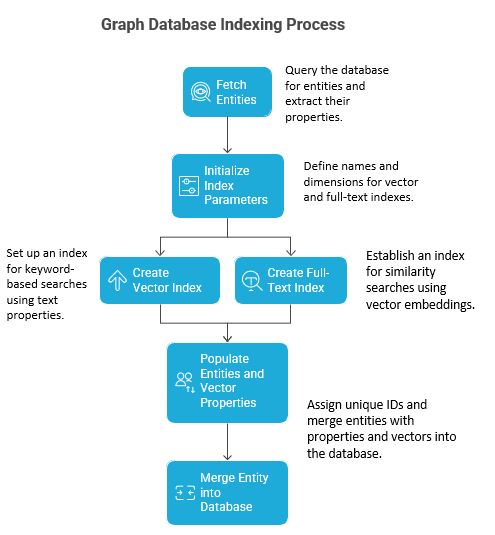

-This code interacts with a Neo4j graph database to create and populate indexes for efficient data retrieval.

  Here's a breakdown:

  - **Fetch Entities:** It starts by querying the database for nodes labeled __Entity__ and extracts their properties.

  - **Initialize Index Parameters:** It defines names for a vector index (entity_vector_index) and a full-text index (entity_fulltext_index), along with the dimension size for the vector embeddings (1536).

  - **Create Vector Index:** It creates a vector index on the __Entity__ label, using the vectorProperty for embeddings and cosine similarity. This index allows for efficient similarity searches based on the vector representations of the entities.

  - **Create Full-Text Index:** It creates a full-text index on the __Entity__ label, indexing various text properties like location, theme, bio, etc. This index enables fast keyword-based searches.

  - **Populate Entities and Vector Properties:** It iterates through the fetched entities. If an entity doesn't have an id, it assigns a new UUID. It then prepares the entity properties and its corresponding vector (if it exists).

  Finally, it uses a Cypher query to merge the entity into the database (creating it if it doesn't exist), setting its properties and the vector property.
  
  In essence, this code prepares the graph database for efficient searching by creating specialized indexes and ensuring that entities have unique identifiers and associated vector embeddings.



In [ ]:
import uuid
from neo4j_graphrag.indexes import create_fulltext_index, create_vector_index

def fetch_entities(driver):
    """Fetches entities from the Neo4j database."""
    cypher = """MATCH (n:__Entity__)
    RETURN properties(n) AS props
    """
    with driver.session() as session:
        results = session.run(cypher).data()
    return [record["props"] for record in results]

def get_unique_entity_properties():
    cypher = """
    MATCH (n:`__Entity__`)
    UNWIND keys(n) AS property
    RETURN DISTINCT property ORDER BY property
    """
    with driver.session() as session:
        result = session.run(cypher)
        # Extract property values into a Python list
        return [record["property"] for record in result]

def create_indexes(driver, dimension):
    """Creates vector and full-text indexes in the Neo4j database."""
    INDEX_NAME = "entity_vector_index"
    FULLTEXT_INDEX_NAME = "entity_fulltext_index"

    create_vector_index(
        driver,
        INDEX_NAME,
        label="__Entity__",
        embedding_property="vectorProperty",
        dimensions=dimension,
        similarity_fn="cosine",
    )

    create_fulltext_index(
        driver,
        FULLTEXT_INDEX_NAME,
        label="__Entity__",
        node_properties=get_unique_entity_properties()
    )

def populate_entities(driver, entities):
    """Populates entities and their vector properties in the Neo4j database."""
    for entity in entities:
        if not entity.get("entity_id"):
            entity["entity_id"] = str(uuid.uuid4())
        props = entity.copy()
        vector = props.pop("embedding", None)
        params = {"props": props}

        if vector is not None:
            params["vector"] = vector
            driver.execute_query("""
            MERGE (n:__Entity__ {entity_id: $props.entity_id})
            SET n += $props
            WITH n
            CALL db.create.setNodeVectorProperty(n, 'vectorProperty', $vector)
            RETURN n
            """, params)
        else:
            driver.execute_query("""
            MERGE (n:__Entity__ {entity_id: $props.entity_id})
            SET n += $props
            RETURN n
            """, params)



# Main execution
DIMENSION = 1536  # your embedding size

entities = fetch_entities(driver)
create_indexes(driver, DIMENSION)
populate_entities(driver, entities)

# Retrieve Data from Knowledge Graph

The GraphRAG Python package provides multiple classes for retrieving data from your knowledge graph, including:

- **Vector Retriever:** performs similarity searches using vector embeddings

- **Vector Cypher Retriever:** combines vector search with retrieval queries in Cypher, Neo4j’s Graph Query language, to traverse the graph and incorporate additional nodes and relationships.

- **Hybrid Retriever:** Combines vector and full-text search.

- **Hybrid Cypher Retriever:** Combines vector and full-text search with Cypher retrieval queries for additional graph traversal.

- **Text2Cypher:** converts natural language queries into Cypher queries to run against Neo4j.

## Vector Retriever

The Vector Retriever uses Approximate Nearest Neighbor (ANN) vector search to retrieve data from your knowledge graph.

You can then instantiate the vector retriever using the code below:

In [ ]:
from neo4j_graphrag.retrievers import VectorRetriever

vector_retriever = VectorRetriever(
   driver,
   index_name="entity_vector_index",
   embedder=embedder,
   #return_properties=["text"],
)

Now, let’s run this retriever with a simple prompt. The retriever can pull back text chunks and vector similarity scores, providing some useful context for answering questions in RAG.

In [ ]:
import json

vector_res = vector_retriever.get_search_results(query_text = "Which Sessions deals with knowledge graphs?",
             top_k=3)
for i in vector_res.records: print("====n" + json.dumps(i.data(), indent=4))

====n{
    "node": {
        "title": "LLMOps \u2013 Productionalizing Real-World Applications with LLMs and Agents",
        "instructor": "Kartik Nighania",
        "prerequisites": [
            "Basic Python programming skills",
            "basic understanding of machine learning concepts",
            "familiarity with AWS services"
        ],
        "louvain": 125,
        "description": "Ready to go from experimentation to production with LLMs? This hands-on session will guide you through training language models using HuggingFace, building Retrieval Augmented Generation (RAG) pipelines with Qdrant, and deploying automated training workflows on Amazon SageMaker. You'll also learn how to orchestrate multi-agent workflows using LangGraph and test, monitor, and evaluate your models with LangSmith. Through practical labs, participants will build end-to-end, production-ready GenAI systems that prioritize scalability, reliability, and real-world performance, equipping you with the t

## Vector Cypher Retriever

Another useful retriever to explore is the Vector Cypher Retriever, which lets you use Cypher, Neo4j’s graph query language, to incorporate graph traversal logic after retrieving an initial set of nodes with vector search. Below we create a retriever to obtain relevant nodes via vector search, then traversing out on entities up to 3 hops out.

In [ ]:
from neo4j_graphrag.retrievers import VectorCypherRetriever

vc_retriever = VectorCypherRetriever(
   driver,
   index_name="entity_vector_index",
   embedder=embedder,
   retrieval_query = """MATCH (w:Workshop)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN w.title AS name, w.description AS description, w.duration AS duration, w.start_time AS start_time
UNION
MATCH (s:Session)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN s.title AS name, s.description AS description, NULL AS duration, NULL AS start_time"""
)

Submitting the same prompt, here’s the context we get back:

In [ ]:
vc_res = vc_retriever.get_search_results(query_text = "List down all the sessions or workshops which uses LangGraph?", top_k=3)

# print output
vc_res

RawSearchResult(records=[<Record name='Mastering Intelligent Agents: A Deep Dive into Agentic AI' description=['A comprehensive, hands-on workshop covering the breadth and depth of Agentic AI Systems, including learning, building, deploying, and monitoring Agentic AI and Agentic RAG Systems. The workshop includes six modules: Introduction to Generative & Agentic AI, Building Basic Agentic AI Systems, Memory Management & Building Conversational Agentic AI Systems, Building Advanced Agentic AI Systems, Building Agentic RAG Systems, and Deploying & Monitoring Agentic AI Systems. Participants will use frameworks such as LangChain, LangGraph, CrewAI, FastAPI, LangFuse, Arize AI Phoenix, and platforms like Google Colab and Runpod.io. Prerequisites include understanding of Python, NLP, and Generative AI.', 'Comprehensive coverage and deep dive into Agentic AI Systems, including learning, building, deploying, and monitoring Agentic AI Systems. Covers Generative AI, Agentic AI, Agentic RAG Syst

### Limitations of Vector Retrieval

**Domain-specific limitations**: Vector search can struggle with domain-specific terms or jargon that are not well-represented in the embedding model’s training data.

**Not ideal for precise string matching**: It may not accurately find results when the query depends on exact matches for specific names, numbers, or dates.


## Full-Text Indexes
Fortunately, there is a solution to this issue: full-text indexes. Unlike vector indexes, which match strings based on semantic similarity, full-text indexes match pieces of text based on lexical similarity, meaning they compare the exact wording or text structure.

## Hybrid Retriever




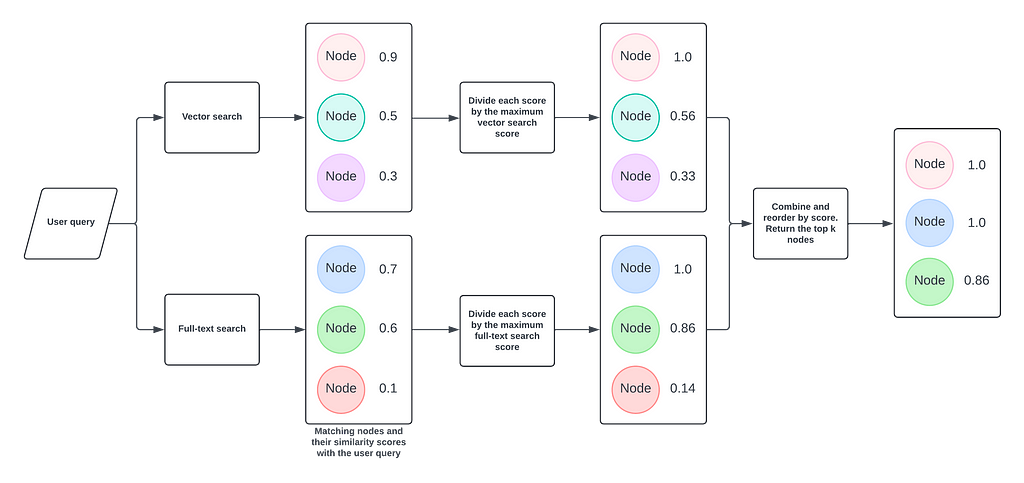

We can use full-text indexes for our GraphRAG applications by using the HybridRetriever class from the Neo4j GraphRAG Python library. This retriever leverages both a vector index and a full-text index in a process known as hybrid search. It uses the user query to search both indexes, retrieving nodes and their corresponding scores. After normalizing the scores from each set of results, it merges them, ranks the combined results by score, and returns the top matches.

In [ ]:
from neo4j_graphrag.retrievers import HybridRetriever

hybrid_retriever = HybridRetriever(
    driver=driver,
    vector_index_name="entity_vector_index",
    fulltext_index_name="entity_fulltext_index",
    embedder=embedder,
    #return_properties=["title", "plot"],
)

query_text = "Who is delivering a workshop on Agentic RAG?"

retriever_result = hybrid_retriever.search(query_text=query_text, top_k=3)
retriever_result

RetrieverResult(items=[RetrieverResultItem(content="{'title': 'Mastering LLMs: Training, Fine-Tuning, and Best Practices', 'instructor': 'Raghav Bali', 'level': 'beginner', 'prerequisites': ['Basics/hands-on experience of working with python', 'Basic understanding of Deep Neural Networks (pytorch preferably)', 'Access to google-colab or similar python environment with GPU access'], 'louvain': 198, 'description': ['This workshop is designed to provide a comprehensive overview of LLMs, right from foundational NLP concepts to the latest in this domain. This workshop is aimed at working professionals but covers the required details to help beginners get started. You will gain valuable insights and hands-on experience to learn & adapt concepts to your professional lives.', 'This workshop is designed to provide a comprehensive overview of LLMs, right from foundational NLP concepts to the latest in this domain. This workshop is aimed at working professionals but covers the required details to

## Hybrid Cypher Retriever
The HybridCypherRetriever enhances the hybrid search process by adding a graph traversal step. It begins by identifying an initial set of nodes through a combined search over vector and full-text indexes, then uses a specified Cypher query to retrieve additional information from the graph for each of these nodes.

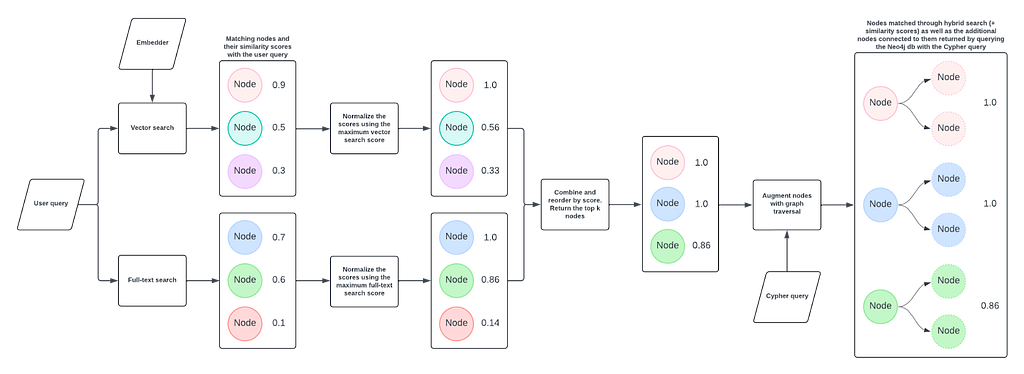

To make use of this retriever, we first need to write a Cypher query to specify exactly what additional information to fetch along with each of the nodes retrieved through hybrid search. Given we are looking to answer questions about actors in movies, we can use the following query:

In [ ]:
retrieval_query = """MATCH (w:Workshop)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN w.title AS name, w.description AS description, w.duration AS duration, w.start_time AS start_time
UNION
MATCH (s:Session)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('LangGraph')
RETURN s.title AS name, s.description AS description, NULL AS duration, NULL AS start_time"""

We then pass this query to the HybridCypherRetriever with the names of the vector and full-text indexes we want to search.

In [ ]:
from neo4j_graphrag.retrievers import HybridCypherRetriever

hc_retriever = HybridCypherRetriever(
    driver=driver,
    vector_index_name="entity_vector_index",
    fulltext_index_name="entity_fulltext_index",
    retrieval_query=retrieval_query,
    embedder=embedder,
)
query_text = "List down all the sessions or workshops which uses LangGraph?"
retriever_result = hc_retriever.search(query_text=query_text, top_k=3)
print(retriever_result)

items=[RetrieverResultItem(content="<Record name='Mastering Intelligent Agents: A Deep Dive into Agentic AI' description=['A comprehensive, hands-on workshop covering the breadth and depth of Agentic AI Systems, including learning, building, deploying, and monitoring Agentic AI and Agentic RAG Systems. The workshop includes six modules: Introduction to Generative & Agentic AI, Building Basic Agentic AI Systems, Memory Management & Building Conversational Agentic AI Systems, Building Advanced Agentic AI Systems, Building Agentic RAG Systems, and Deploying & Monitoring Agentic AI Systems. Participants will use frameworks such as LangChain, LangGraph, CrewAI, FastAPI, LangFuse, Arize AI Phoenix, and platforms like Google Colab and Runpod.io. Prerequisites include understanding of Python, NLP, and Generative AI.', 'Comprehensive coverage and deep dive into Agentic AI Systems, including learning, building, deploying, and monitoring Agentic AI Systems. Covers Generative AI, Agentic AI, Agent

In [ ]:
retrieval_query = """MATCH (w:Workshop)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('Neo4j')
RETURN properties(w) AS props
UNION
MATCH (s:Session)-[:USES]->(t:Tool)
WHERE toLower(t.name) CONTAINS toLower('Neo4j')
RETURN properties(s) AS props;
"""


In [ ]:
from neo4j_graphrag.retrievers import HybridCypherRetriever

hc_retriever = HybridCypherRetriever(
    driver=driver,
    vector_index_name="entity_vector_index",
    fulltext_index_name="entity_fulltext_index",
    retrieval_query=retrieval_query,
    embedder=embedder,
)
query_text = "List down all the sessions or workshops which uses Neo4j?"
retriever_result = hc_retriever.search(query_text=query_text, top_k=3)
retriever_result

RetrieverResult(items=[RetrieverResultItem(content="<Record props={'instructor': 'Arun Prakash Asokan', 'louvain': 106, 'theme': 'Agentic Knowledge Augmented Generation: The Next Leap After RAG', 'vectorProperty': [0.02844676934182644, 0.03476324677467346, -0.028748271986842155, 0.026698054745793343, 0.005046399775892496, -0.014600262977182865, 0.009225979447364807, 0.012075178325176239, 0.0030301010701805353, 0.011570162139832973, 0.022205665707588196, -0.04968762770295143, -0.024512160569429398, -0.030240708962082863, 0.0015028020134195685, -3.9130562072386965e-05, -0.02020067349076271, -0.06753657758235931, -0.009602857753634453, -0.007488570641726255, 0.019386617466807365, -0.02143683470785618, 0.019461991265416145, 0.03527580201625824, -0.031205518171191216, -0.01947706751525402, -0.004944642540067434, 0.05710459128022194, -0.020758453756570816, -0.00832900870591402, 0.008148107677698135, -0.043898776173591614, 0.003923302516341209, -0.04950672388076782, 0.03506474941968918, 0.067

## Text2Cypher Retriever

This retriever first asks an LLM to generate a Cypher query to fetch the exact information required to answer the question from the database. Then this query is executed and the resulting records are added to the context for the LLM to write the answer to the initial user question.

The workflow for generating Cypher queries from natural language questions can
be broken down into the following steps:
- Retrieve the question from the user.
- Retrieve the schema of the knowledge graph.
- Define other useful information like terminology mappings, format instructions, and few-shot examples.
- Generate the prompt for the LLM.
- Pass the prompt to the LLM to generate the Cypher query.


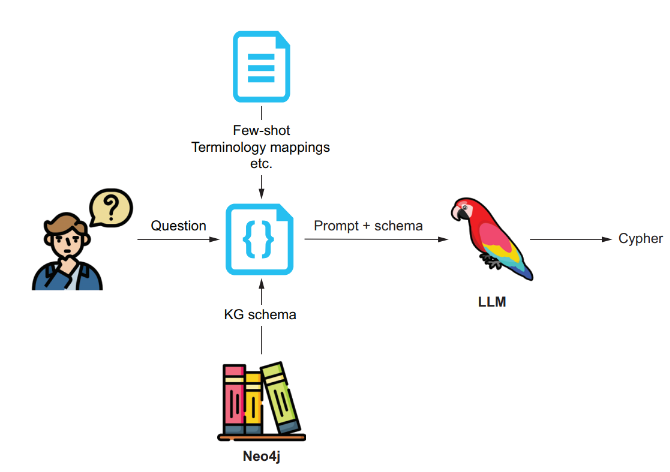

In [ ]:
from neo4j_graphrag.retrievers import Text2CypherRetriever
import prompts
from examples import examples
from neo4j_graphrag.schema import get_schema

# Initialize the Text2Cypher retriever
t2c_retriever = Text2CypherRetriever(
    llm=llm,
    neo4j_schema=get_schema(driver),
    driver=driver,
    custom_prompt=prompts.custom_text2cypher_prompt,
    examples=examples
)

# Define a sample query in natural language
query_text = "List the names and session titles of all speakers."

# Use the retriever to convert the natural language query to a Cypher query and execute it
response = t2c_retriever.search(query_text=query_text)

# Print the generated Cypher query and the results
print("Generated Cypher Query:")
print(response.metadata['cypher'])
print("\nResults:")
for record in response.items:
    print(record.content)

Generated Cypher Query:
MATCH (s:Speaker)-[:PRESENTS]->(sess:Session)
RETURN DISTINCT s.name AS speaker_name, sess.title AS session_title

Results:
<Record speaker_name='Kartik Nighania' session_title='Agents at Scale: Engineering Reliable GenAI Systems for Production'>
<Record speaker_name='Arun Prakash Asokan' session_title='Agentic Knowledge Augmented Generation: The Next Leap After RAG'>
<Record speaker_name='Miguel Otero Pedrido' session_title='Beyond PoCs: Building Real-World Agentic Systems'>
<Record speaker_name='Dr. Kiran R' session_title='Responsible AI in Medical Imaging – A Case Study'>
<Record speaker_name='Dr. Kiran R' session_title='Evaluating GenAI Models: Case Studies in Enterprise and Healthcare'>
<Record speaker_name='Jayita Bhattacharyya' session_title='Scaling Test-time Inference Compute & Advent of Reasoning Models'>
<Record speaker_name='Chi Wang' session_title='MassGen: Scaling AI Through Multi-Agent Collaboration'>
<Record speaker_name='Krishna Kumar Tiwari' se

In [ ]:
from neo4j_graphrag.retrievers import Text2CypherRetriever
import prompts
from examples import examples
from neo4j_graphrag.schema import get_schema

# Initialize the Text2Cypher retriever
t2c_retriever = Text2CypherRetriever(
    llm=llm,
    neo4j_schema=get_schema(driver),
    driver=driver,
    custom_prompt=prompts.custom_text2cypher_prompt,
    examples=examples
)

# Define a sample query in natural language
query_text = "List the names and session titles of all speakers."

# Use the retriever to convert the natural language query to a Cypher query and execute it
response = t2c_retriever.search(query_text=query_text)

# Print the generated Cypher query and the results
print("Generated Cypher Query:")
print(response.metadata['cypher'])
print("\nResults:")
for record in response.items:
    print(record.content)

Generated Cypher Query:
MATCH (s:Speaker)-[:PRESENTS]->(se:Session)
RETURN DISTINCT s.name AS speaker_name, se.title AS session_title

Results:
<Record speaker_name='Kartik Nighania' session_title='Agents at Scale: Engineering Reliable GenAI Systems for Production'>
<Record speaker_name='Arun Prakash Asokan' session_title='Agentic Knowledge Augmented Generation: The Next Leap After RAG'>
<Record speaker_name='Miguel Otero Pedrido' session_title='Beyond PoCs: Building Real-World Agentic Systems'>
<Record speaker_name='Dr. Kiran R' session_title='Responsible AI in Medical Imaging – A Case Study'>
<Record speaker_name='Dr. Kiran R' session_title='Evaluating GenAI Models: Case Studies in Enterprise and Healthcare'>
<Record speaker_name='Jayita Bhattacharyya' session_title='Scaling Test-time Inference Compute & Advent of Reasoning Models'>
<Record speaker_name='Chi Wang' session_title='MassGen: Scaling AI Through Multi-Agent Collaboration'>
<Record speaker_name='Krishna Kumar Tiwari' sessio

In [ ]:
# Define a sample query in natural language
query_text = "List the names of speakers who are speaking more than once"

# Use the retriever to convert the natural language query to a Cypher query and execute it
response = t2c_retriever.search(query_text=query_text)

# Print the generated Cypher query and the results
print("Generated Cypher Query:")
print(response.metadata['cypher'])
print("\nResults:")
for record in response.items:
    print(record.content)

Generated Cypher Query:
MATCH (s:Speaker)-[:PRESENTS]->(sess:Session)
WITH s, COUNT(sess) AS session_count
WHERE session_count > 1
RETURN DISTINCT s.name

Results:
<Record s.name='Dr. Kiran R'>
<Record s.name='Krishna Kumar Tiwari'>
<Record s.name='Manoranjan Rajguru'>
<Record s.name='Dipanjan Sarkar'>
<Record s.name='Ranjani Mani'>
<Record s.name='Aditya Iyengar'>
<Record s.name='Daksh Varshneya'>
<Record s.name='Aashay Sachdeva'>
<Record s.name='Mayank Aggarwal'>
<Record s.name='Kunal Jain'>
<Record s.name='Anand S'>
<Record s.name='Praneeth Paikray'>
<Record s.name='Kuldeep Jiwani'>
<Record s.name='Pranjal Singh'>
<Record s.name='Sanathraj Narayan'>


# GraphRAG

To turn the retriever search into a full GraphRAG pipeline, we simply add the following code:

In [ ]:
from neo4j_graphrag.generation import GraphRAG
from IPython.display import display, Markdown
import json

def query_graph(retriever, llm, query_text, retriever_config):
  """Queries the graph using a GraphRAG pipeline.

  Args:
    retriever: The retriever to use.
    llm: The language model to use.
    query_text: The query text.
    retriever_config: The retriever configuration.

  Returns:
    The response from the GraphRAG pipeline.
  """
  # Initialize the RAG pipeline
  rag = GraphRAG(retriever=retriever, llm=llm)

  # Query the graph
  response = rag.search(query_text=query_text,
                        retriever_config=retriever_config,
                        return_context=True,
                        response_fallback="I can not answer this question because I have no relevant context."
                        )
  return response.answer

def run_all_retrievers(query_text, top_k_value=5):
    """Runs the query through all initialized retrievers and displays the results."""

    # Get results from Vector Retriever using query_graph function
    display(Markdown("### Vector Retriever Results (using GraphRAG)"))
    response = query_graph(vector_retriever, llm, query_text, {"top_k": top_k_value})
    display(Markdown(response))

    # Get results from Vector Cypher Retriever using query_graph function
    display(Markdown("### Vector Cypher Retriever Results (using GraphRAG)"))
    response = query_graph(vc_retriever, llm, query_text, {"top_k": top_k_value})
    display(Markdown(response))

    # Get results from Text2Cypher Retriever using the query_graph function
    display(Markdown("### Text2Cypher Retriever Results (using GraphRAG)"))
    response = query_graph(t2c_retriever, llm, query_text, {})
    display(Markdown(response))

    # Get results from Hybrid Retriever using query_graph function
    display(Markdown("### Hybrid Retriever Results (using GraphRAG)"))
    response = query_graph(hybrid_retriever, llm, query_text, {"top_k": top_k_value})
    display(Markdown(response))

    # Get results from Hybrid Cypher Retriever using the query_graph function
    display(Markdown("### Hybrid Cypher Retriever Results (using GraphRAG)"))
    response = query_graph(hc_retriever, llm, query_text, {"top_k": top_k_value})
    display(Markdown(response))


query_text = "List down all the sessions or workshops which uses Neo4j?"
run_all_retrievers(query_text)

### Vector Retriever Results (using GraphRAG)

Based on the provided context, there are no sessions or workshops listed that mention the use of Neo4j. The sessions and workshops described use tools such as Google Colab, Azure Document Intelligence, Chroma Vector DB, LangChain, LangGraph, Langfuse, and others, but Neo4j is not mentioned as a tool used in any of them.

### Vector Cypher Retriever Results (using GraphRAG)

None of the listed sessions or workshops mention the use of Neo4j.

### Text2Cypher Retriever Results (using GraphRAG)

The session "Agentic Knowledge Augmented Generation: The Next Leap After RAG" uses Neo4j Graph Database as the backend to power graph traversal and reasoning.

### Hybrid Retriever Results (using GraphRAG)

Here are the sessions or workshops that use Neo4j:

1. Agentic Knowledge Augmented Generation: The Next Leap After RAG
   - Instructor: Arun Prakash Asokan
   - Description: This live hack session will build a Knowledge Graph from scratch using a relatable dataset, use Neo4j Graph Database as the backend to power graph traversal and reasoning, and demonstrate end-to-end Agentic Knowledge Augmented Generation (KAG) pipelines.
   - Tools Discussed: Neo4j Graph Database, Chroma DB, ReAct Agents, Langfuse

Neo4j is specifically mentioned as a tool used in this session. No other session in the provided context lists Neo4j as a tool.

### Hybrid Cypher Retriever Results (using GraphRAG)

Based on the provided context, the following session uses Neo4j:

- **Session Title:** Agentic Knowledge Augmented Generation: The Next Leap After RAG  
  **Instructor:** Arun Prakash Asokan  
  **Session Type:** Hack Session  
  **Day:** Day 1  
  **Date:** 2025-08-20  
  **Start Time:** 12:00PM  
  **End Time:** 12:50PM  
  **Tools Discussed:** Neo4j Graph Database, Chroma DB, ReAct Agents, Langfuse  
  **Description:**  
  This session demonstrates building a Knowledge Graph from scratch using a relatable dataset, with Neo4j Graph Database as the backend to power graph traversal and reasoning. The session also covers Chroma DB for RAG scenarios, ReAct Agents for step-by-step reasoning, and Langfuse for traceability and observability.

**Summary:**  
Neo4j is used in the session "Agentic Knowledge Augmented Generation: The Next Leap After RAG" by Arun Prakash Asokan.

In [ ]:
query_text = "Who won the an award on Gen AI?"
run_all_retrievers(query_text)

### Vector Retriever Results (using GraphRAG)

Arun Prakash Asokan won an award on Gen AI. He was awarded and honoured as the Top Gen AI Leader 2024 by Analytics Vidhya, recognizing his significant contributions and leadership in the field of Generative AI.

### Vector Cypher Retriever Results (using GraphRAG)

There is no information in the provided context about anyone winning an award on Gen AI. The context only describes various workshops and sessions related to Agentic AI, GenAI, and related technologies, but does not mention any awards or winners.

### Text2Cypher Retriever Results (using GraphRAG)

The provided context does not mention anyone winning an award on Gen AI. There is information about Arun Prakash Asokan, who is an Associate Director of Data Science, but no details about a Gen AI award.

### Hybrid Retriever Results (using GraphRAG)

Arun Prakash Asokan won an award on Gen AI. He was recognized as a "Top Gen AI Leader 2024" by Analytics Vidhya, as mentioned in his bio and awards list.

### Hybrid Cypher Retriever Results (using GraphRAG)

The provided context does not mention any individual or entity winning an award on Gen AI. It describes a hack session titled "Agentic Knowledge Augmented Generation: The Next Leap After RAG" by Arun Prakash Asokan at DataHack Summit 2025, focusing on advanced techniques in knowledge-augmented generation, but there is no information about an award related to Gen AI.

In [ ]:
query_text = "Which tools were used in workshops conducted by speakers from Novartis?"
run_all_retrievers(query_text)

### Vector Retriever Results (using GraphRAG)

Based on the provided context, there is no information indicating that any workshops were conducted by speakers from Novartis. Therefore, there are no tools listed as being used in workshops by Novartis speakers.

### Vector Cypher Retriever Results (using GraphRAG)

Based on the provided context, there is no explicit mention of speakers from Novartis or which workshops were conducted by them. Therefore, it is not possible to determine which tools were used in workshops conducted by speakers from Novartis from the given information. If you have additional details or context linking specific workshops to Novartis speakers, please provide them for a more accurate answer.

### Text2Cypher Retriever Results (using GraphRAG)

Based on the provided context, the tools used in workshops conducted by speakers from Novartis include:

- google-colab
- Chroma DB
- LangGraph
- LangFuse
- Azure Data Factory
- LangChain

### Hybrid Retriever Results (using GraphRAG)

Based on the provided context, the workshops conducted by speakers from Novartis include the "Agentic RAG Workshop: From Fundamentals to Real-World Implementations." The tools used in this workshop are:

- Google Colab
- Azure Document Intelligence
- Chroma Vector DB
- LangChain
- LangGraph
- Langfuse

These tools were employed for hands-on practice in building agentic RAG (Retrieval-Augmented Generation) pipelines, document parsing, semantic storage and retrieval, application development, agent orchestration, workflow management, and agentic tracing/evaluation.

### Hybrid Cypher Retriever Results (using GraphRAG)

Based on the provided context, there is no information indicating that any workshops were conducted by speakers from Novartis, nor are there details about tools used by Novartis speakers. The session described is led by Arun Prakash Asokan and discusses tools such as Neo4j Graph Database, Chroma DB, ReAct Agents, and Langfuse, but there is no mention of Novartis or its speakers. Therefore, no tools can be listed for workshops conducted by speakers from Novartis based on the given information.

In [ ]:
run_all_retrievers("Which speakers are affiliated with Bits Pilani, and what sessions are they presenting?")

### Vector Retriever Results (using GraphRAG)

Based on the provided context, there are no speakers listed who are affiliated with BITS Pilani. None of the speaker bios or profiles mention BITS Pilani as their current or past institution or organization. Therefore, there are no sessions being presented by speakers from BITS Pilani in the given information.

### Vector Cypher Retriever Results (using GraphRAG)

The provided context does not include information about speakers or their affiliations, including whether any speakers are affiliated with Bits Pilani. The session records only contain session names, descriptions, durations, and start times, but do not list speaker names or their institutional affiliations. Therefore, based on the given context, it is not possible to determine which speakers are affiliated with Bits Pilani or what sessions they are presenting.

### Text2Cypher Retriever Results (using GraphRAG)

The following speakers are affiliated with BITS Pilani and their respective sessions are:

1. **Arun Prakash Asokan**
   - **Affiliation:** Holds a Master's in Computer Science Engineering from BITS Pilani.
   - **Session:** "Agentic Knowledge Augmented Generation: The Next Leap After RAG" (Hack Session) on 2025-08-20.

2. **Praneeth Paikray**
   - **Affiliation:** Holds an MTech in Data Science from BITS Pilani (2021-2023).
   - **Sessions:**
     - "Adaptive Email Agents with DSPy: From Static Prompts to Smart Learning" (Hack Session) on 2025-08-22.
     - "AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks" (Hack Panel) on 2025-08-22.

3. **Gauri Kholkar**
   - **Affiliation:** Holds a Computer Science degree from BITS Pilani.
   - **Session:** "Deploying GenAI Safely: Strategies for Trustworthy LLMs" (Hack Session) on 2025-08-20.

### Hybrid Retriever Results (using GraphRAG)

Based on the provided context, there are no speakers listed who are affiliated with BITS Pilani. None of the speaker bios or session details mention BITS Pilani as their institution or affiliation. Therefore, there are no sessions being presented by speakers from BITS Pilani in the given information.

### Hybrid Cypher Retriever Results (using GraphRAG)

Based on the provided context, there is no information indicating that any speakers are affiliated with Bits Pilani, nor are there any sessions presented by speakers from Bits Pilani. The only speaker mentioned is Arun Prakash Asokan, who is presenting the session "Agentic Knowledge Augmented Generation: The Next Leap After RAG." No affiliation with Bits Pilani is specified for this speaker.

In [ ]:
run_all_retrievers("Are any of the conference sponsors also represented among the speakers’ companies? If so, which sponsors and which speaker(s) from those companies are present?")

### Vector Retriever Results (using GraphRAG)

Based on the provided context, there is no information about conference sponsors or a list of sponsoring companies. The speaker profiles include:

- Srikanth Velamakanni (Co-founder and Group CEO of Fractal)
- Joshua Starmer (Founder and CEO of Statsquest)

However, without a list of sponsors, it is not possible to determine if any of the conference sponsors are also represented among the speakers’ companies. If you provide a list of sponsors, I can cross-reference it with the speakers’ affiliations to answer your question.

### Vector Cypher Retriever Results (using GraphRAG)

The provided context does not include information about conference sponsors or the companies that the speakers represent. Therefore, based on the given information, it is not possible to determine whether any of the conference sponsors are also represented among the speakers’ companies. To answer this question, details about both the sponsors and the speakers’ affiliations would be required.

### Text2Cypher Retriever Results (using GraphRAG)

I can not answer this question because I have no relevant context.

### Hybrid Retriever Results (using GraphRAG)

Based on the provided context, there is no information about the conference sponsors or a list of sponsoring companies. The available data includes details about speakers, their affiliations, and session information, but does not mention any sponsors.

Therefore, I cannot determine if any of the conference sponsors are also represented among the speakers’ companies. If you provide a list of sponsors, I can cross-reference it with the speakers’ affiliations to answer your question.

### Hybrid Cypher Retriever Results (using GraphRAG)

The provided context does not include information about conference sponsors or the companies that speakers represent. Therefore, based on the given data, it is not possible to determine if any of the conference sponsors are also represented among the speakers’ companies, or to identify which sponsors and speakers might overlap. Additional information about sponsors and speaker affiliations would be needed to answer this question.

In [ ]:
run_all_retrievers("Are there any speakers who are presenting multiple sessions or both giving a talk and conducting a workshop? Who are they and what are those events?")

### Vector Retriever Results (using GraphRAG)

Based on the provided context, there is one speaker who is presenting multiple sessions:

**Joshua Starmer** is involved in more than one event:

1. **Workshop:**  
   - **Title:** From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents  
   - **Type:** Hands-on workshop  
   - **Co-instructor:** Luis Serrano  
   - **Description:** Covers LLMs, RL, and building AI agents, with hands-on coding.

2. **Speaker Bio:**  
   - Joshua Starmer is listed as a featured speaker at DataHack Summit 2025, with a bio indicating he will "illuminate the stage" and "engage with audiences" at the event. While the context does not specify the title of his talk, it confirms he is both a workshop instructor and a speaker.

**Summary:**  
- **Joshua Starmer** is both conducting a workshop and giving a talk at the event.

**No other speakers** in the provided context are explicitly listed as presenting multiple sessions or both giving a talk and conducting a workshop. The other instructors (e.g., Pranjal Singh, Arun Prakash Asokan, Alessandro Romano) are each associated with a single session in the context.

**Events involving Joshua Starmer:**
- Workshop: "From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents"
- (Implied) Talk/Keynote: As per his speaker bio at DataHack Summit 2025

**Note:**  
If you have access to the full event schedule, you may find more details about Joshua Starmer's talk. Based on the current context, he is the only confirmed speaker with multiple roles.

### Vector Cypher Retriever Results (using GraphRAG)

Based on the provided context, there is no information about individual speakers’ names or their associations with specific sessions. The session records only include titles, descriptions, and technical details, but do not mention who is presenting or leading each event.

Therefore, it is not possible to determine from the given information whether any speakers are presenting multiple sessions or both giving a talk and conducting a workshop. To answer this question, you would need access to the event’s speaker list or agenda that maps speakers to their sessions.

### Text2Cypher Retriever Results (using GraphRAG)

Yes, several speakers are presenting multiple sessions and/or conducting both talks and workshops at the event. Here are the details:

---

### 1. **Dr. Kiran R**
- **Sessions:**
  - **Responsible AI in Medical Imaging – A Case Study**
  - **Evaluating GenAI Models: Case Studies in Enterprise and Healthcare**

---

### 2. **Krishna Kumar Tiwari**
- **Sessions:**
  - **Collaborative Multi-Agent Framework for Robust SEO Content Generation**
  - **From Language to Robotics: Practical Lessons Bridging LLMs, RL, and AI**
  - **Automating Vehicle Inspections with Multimodal AI and Gemini on GCP**
  - **From Vision to Action: Multi-Modal Agentic AI in Real-World Use**
  - **Zero to Million: How GenAI Agents are Changing Performance Marketing**
  - **Building India’s AI Ecosystem: From Vision to Sovereignty**
  - **Zero to Million: How GenAI Agents are Revolutionizing Performance Marketing**

---

### 3. **Manoranjan Rajguru**
- **Sessions:**
  - **AI Voice Agent: The Future of Human-Computer Interaction**
  - **AI Voice Agents: The Future of Human-Computer Interaction**

---

### 4. **Dipanjan Sarkar**
- **Sessions:**
  - **AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**
  - **Building Effective Agentic AI Systems: Lessons from the Field**
- **Workshop:**
  - **Mastering Intelligent Agents: A Deep Dive into Agentic AI**

---

### 5. **Mayank Aggarwal**
- **Sessions:**
  - **AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**
  - **Automate Everything: Building Agentic AI Workflows with No-Code Tools**

---

### 6. **Aashay Sachdeva**
- **Sessions:**
  - **Post-Training Is Back: From Prompts to Policies**
  - **Post‑Training Is Back: From Prompts to Policies**

---

### 7. **Aditya Iyengar**
- **Sessions:**
  - **Empowering Data Insights with Large Language Models**
  - **Empowering Data Insights with Large Language Models (LLMs)**

---

### 8. **Daksh Varshneya**
- **Sessions:**
  - **Fast and Accurate Conversational Agents: Beyond Function Calling**
  - **Building Fast and Accurate Conversational Agents: Beyond Function Calling**

---

### 9. **Praneeth Paikray**
- **Sessions:**
  - **Adaptive Email Agents with DSPy: From Static Prompts to Smart Learning**
  - **AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**

---

### 10. **Kuldeep Jiwani**
- **Sessions:**
  - **Measuring Uncertainty in LLMs and Optimal Use of SLMs**
  - **Measuring Uncertainty in LLMs and Optimal use of SLMs**

---

### 11. **Pranjal Singh**
- **Sessions:**
  - **Architecting AI: Practical Patterns for Multi-Agentic Workflows**
  - **Architecting Intelligence: Practical Patterns for Multi-Agentic Workflows**

---

### 12. **Sanathraj Narayan**
- **Sessions:**
  - **Mastering Agentic Workflows with LangGraph**
  - **AutoGen vs CrewAI vs LangGraph: Battle of the Agent Frameworks**

---

### 13. **Alessandro Romano**
- **Session:**
  - **From LLMs to Agentic AI: Solving New Problems with Multi-Agent Systems**
- **Workshop:**
  - **Mastering Real-World Multi-Agent Systems**

---

### 14. **Chi Wang**
- **Session:**
  - **MassGen: Scaling AI Through Multi-Agent Collaboration**
- **Workshop:**
  - **Mastering Real-World Agentic AI Applications with AG2 (AutoGen)**

---

### 15. **Kartik Nighania**
- **Session:**
  - **Agents at Scale: Engineering Reliable GenAI Systems for Production**
- **Workshop:**
  - **LLMOps – Productionalizing Real-World Applications with LLMs and Agents**

---

### 16. **Bhaskarjit Sarmah**
- **Session:**
  - **Detecting and Mitigating Risks in Agentic AI**
- **Workshop:**
  - **AgentOps: Building and Deploying AI Agents**

---

### 17. **Joshua Starmer**
- **Session:**
  - **Quantifying Our Confidence in Neural Networks and AI**
- **Workshop:**
  - **From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents**

---

### 18. **Luis Serrano**
- **Session:**
  - **A Visual Guide to Attention Mechanism in LLMs**
- **Workshop:**
  - **From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents**

---

### 19. **Miguel Otero Pedrido**
- **Session:**
  - **Beyond PoCs: Building Real-World Agentic Systems**
- **Workshop:**
  - **Building Intelligent Multimodal Agents: Integrating Vision, Speech & Language**

---

### 20. **Arun Prakash Asokan**
- **Session:**
  - **Agentic Knowledge Augmented Generation: The Next Leap After RAG**
- **Workshop:**
  - **Agentic RAG Workshop: From Fundamentals to Real-World Implementations**

---

**Note:**  
- Some sessions have slightly different titles but are essentially the same talk (e.g., minor wording differences or subtitle changes).
- Many speakers are both giving talks and conducting workshops, especially those with deep expertise in Agentic AI, LLMs, and GenAI systems.

If you need a more concise list or want to know about a specific speaker, let me know!

### Hybrid Retriever Results (using GraphRAG)

Based on the provided context, there is one speaker who is presenting multiple sessions at DataHack Summit 2025:

**Joshua Starmer**  
- **Workshop:**  
  - Title: *From Beginner to Expert: Learning LLMs, Reinforcement Learning & AI Agents*  
  - Co-instructor: Luis Serrano  
  - Description: Hands-on workshop covering LLMs, RL, and AI agents, including building, training, and fine-tuning LLMs, as well as using RAG and AI agents.
- **Bio:**  
  - Joshua Starmer is listed as a speaker with a detailed biography, indicating his active participation at the event.

However, based on the context, there is no explicit mention of Joshua Starmer giving a separate talk in addition to the workshop, nor is there evidence of any other speaker presenting both a talk and a workshop or leading multiple sessions.

**Summary:**  
- **Joshua Starmer** is the only speaker in the provided context who is confirmed to be involved in more than one capacity (as a workshop instructor and as a featured speaker with a bio).  
- No other speakers are shown to be presenting multiple sessions or both a talk and a workshop in the given data.

If you have more data or a full schedule, there may be additional speakers with multiple roles, but from the current context, only Joshua Starmer fits this criterion.

### Hybrid Cypher Retriever Results (using GraphRAG)

Based on the provided context, there is information about a single session titled "Agentic Knowledge Augmented Generation: The Next Leap After RAG," which is conducted by Arun Prakash Asokan. There is no information in the context about Arun Prakash Asokan (or any other speaker) presenting multiple sessions, giving both a talk and a workshop, or participating in more than one event.

**Summary:**  
- **Speaker:** Arun Prakash Asokan  
- **Session:** "Agentic Knowledge Augmented Generation: The Next Leap After RAG" (Hack Session)  
- **No evidence in the provided context of any speaker presenting multiple sessions or both giving a talk and conducting a workshop.**

If you have more session data or a list of all sessions and speakers, I can help cross-reference for multiple appearances. With the current context, only one session and one speaker are mentioned.